# 1. Project Overview

This project focuses on developing a robust and scalable solution for classifying news articles into relevant categories, utilizing both traditional machine learning and modern deep learning techniques. We leverage the [**News Category Dataset**](https://www.kaggle.com/datasets/rmisra/news-category-dataset), which consists of headlines and short descriptions of over 200,000 news articles from 2012 to 2022, spanning 42 different topics such as Politics, Technology, and Entertainment out of which we will use top 15 categories.

This notebook can be accessed from github repository [**Github Repository**](https://github.com/Satwik-Sharma-dot/news_category_classification), it contains the requirements.txt as well. 

### Project Objectives:
- **Accurate Classification:** Our goal is to classify news articles into their respective categories with high accuracy using state-of-the-art models.
- **Model Comparisons:** We will compare the performance of traditional machine learning algorithms with advanced deep learning approaches.
- **Efficient Text Preprocessing:** We’ll implement data cleaning, feature extraction, and text processing techniques to enhance model performance.
- **Transfer Learning:** By applying transfer learning techniques with pre-trained models such as BERT and RoBERTa, we aim to leverage cutting-edge natural language processing (NLP) methods.
- **Comprehensive Evaluation:** Detailed model evaluation using key metrics such as accuracy, precision, recall, and F1-score will provide insights into the best-performing approach.

### Key Challenges:
- **Class Imbalance:** Some categories have significantly more data than others, which may affect model performance.
- **Subtle Differences Between Categories:** Certain categories, such as “Politics” and “World News,” have overlapping content, making classification more complex.

Through this project, we aim to deliver a comprehensive text classification pipeline that can serve as a foundation for similar NLP tasks in production environments.


In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob

In [2]:
# Importing the data

df = pd.read_json(r"C:\Users\satwik.sharma\Downloads\News_Category_Dataset_v3.json",lines = True)

## 2. Dataset Overvew and Structure
To begin, we load the dataset and inspect its struture to understand the available features and their data types.

In [3]:
df.sample(5)

,link,headline,category,short_description,authors,date
130494,https://www.huffingtonpost.com/entry/ukraine-u...,Pro-Russian Rebels Force Closure Of Donetsk Ai...,WORLDPOST,,,2014-05-26
45382,https://www.huffingtonpost.com/entry/the-obama...,"The Obamas Have Left The Building, But Not Soc...",POLITICS,How to keep in touch with @POTUS and @FLOTUS p...,Rebecca Shapiro,2017-01-20
10561,https://www.huffingtonpost.com/entry/trump-tow...,Trump Presidency Is Taking The Luster Off Trum...,POLITICS,The high-rise with the stunning views of Centr...,S.V. Date,2018-04-21
198976,https://www.huffingtonpost.com/entry/the-view-...,The View's 'Fat Show': The Co-Hosts And Lead E...,WELLNESS,"But no matter what you call it, the show delve...",,2012-05-21
102962,https://www.huffingtonpost.com/entry/mindy-kal...,Mindy Kaling's Brother Sets Record Straight On...,BLACK VOICES,,Emily Tess Katz,2015-04-07


#### The datast contains 5 independent features and the dependent feature.

Independent Features
- Link - Link to the article.
- Headline - Headling of the article.
- short_description - Short description of the article.
- Authors - Contains the names of authors.
- Date - date in yyyy-mm-dd format.

Dependent Features
- Category - Contains different categories which we have to classify.

## 3. Exploratory Data Analysis (EDA)

This section explores the dataset to identify patterns and understand distributions.
It also explores trend overtime and similarities between classes. 

In [4]:
# Get an overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


- The dataset contains 209,527 entries across 6 columns, all of which are non-null. The key columns for our analysis will be `headline`, `short_description`, and `category`. The `date` column is in datetime format, useful for time-based analysis.


In [5]:
# Summary of the dataset
df[['headline','category','authors']].describe()

,headline,category,authors
count,209527,209527,209527
unique,207996,42,29169
top,Sunday Roundup,POLITICS,
freq,90,35602,37418


- The dataset includes 208,527 headlines, 42 unique categories, and 29,169 unique authors. The most frequent category is "POLITICS" (35,602 occurrences), indicating a class imbalance.


In [6]:
# Checking for missing values 
print(f"Total number of missing values in each category: \n{df.isnull().sum()}")

Total number of missing values in each category: 
link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64


- There are no missing values in the dataset. 
- We can look for duplicated rows next. 

In [7]:
# Checking for duplicates in 'headline' and 'short_description' columns
duplicates = df[df.duplicated(subset=['headline', 'short_description'], keep='first')]

# Visualizing duplicate occurrences
print(f"Number of duplicate rows: {duplicates.shape[0]}")

print(f"Number of rows after removing duplicates: {df.shape[0]}")


Number of duplicate rows: 489
Number of rows after removing duplicates: 209527


- There were 489 duplicated rows, which have been removed. Remaining number of rows: 209527

In [8]:
# Code cell to ignore warnings
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [9]:
# Get the top 15 categories by size
top_15_categories = df['category'].value_counts().index[:15]

# Filter the DataFrame to include only the rows with those top 15 categories
df_top15 = df[df['category'].isin(top_15_categories)]

# Check the distribution of categories in the filtered DataFrame
print(df_top15['category'].value_counts())

category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
Name: count, dtype: int64


- We filtered out the top 15 categories to do further exploratory data analysis on those.
- We can see the class imbalance as the top 3 columns have very high amount of data. 

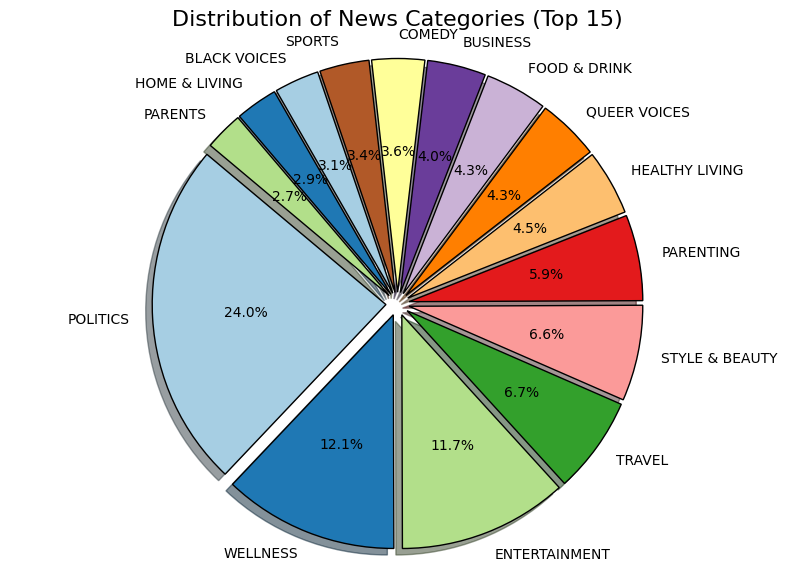

In [10]:
# Code block to plot class distribution
import matplotlib.pyplot as plt

# Get category counts and labels
category_counts = df_top15['category'].value_counts()
labels = category_counts.index

# Define the explode values to highlight certain categories
explode = [0.05] * len(labels)  # Slightly "explode" each slice

# Define colors (optional for a better look)
colors = plt.cm.Paired.colors  # Use a colormap for a nicer color scheme

# Create a pie chart
plt.figure(figsize=(10, 7))
plt.pie(
    category_counts,
    explode=explode,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',  # Display percentages
    startangle=140,      # Rotate the start angle for better view
    shadow=True,         # Add shadow for effect
    wedgeprops={'edgecolor': 'black'}  # Black edge around slices
)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')  
plt.title('Distribution of News Categories (Top 15)', fontsize=16)
plt.show()

- Politics has the highest amount of data(24%).
- Wellness, Politics, Entertainment combined consists of ~50% of the data which shows a heavy class imbalance.
- Undersampling, Oversampling, class weights can be used to deal with this class imbalance.

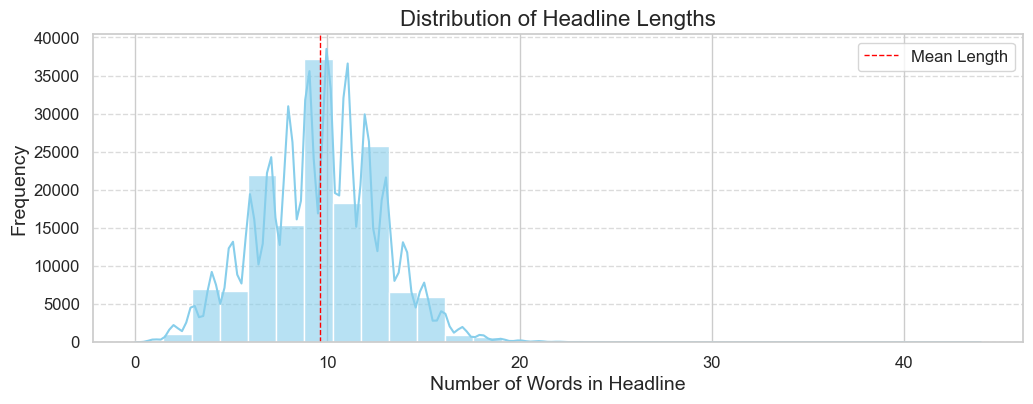

In [11]:
# Code block to see the headline lengths
# Setting the style and palette
# Assuming the column 'headline' contains the headlines
df_top15['headline_length'] = df_top15['headline'].apply(lambda x: len(str(x).split()))

sns.set(style="whitegrid", palette="muted")

# Plot the distribution of headline lengths with improved aesthetics
plt.figure(figsize=(12,4))
sns.histplot(df_top15['headline_length'], bins=30, kde=True, color='skyblue', alpha=0.6)
plt.title('Distribution of Headline Lengths', fontsize=16)
plt.xlabel('Number of Words in Headline', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axvline(df_top15['headline_length'].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean Length')
plt.legend(fontsize=12)
plt.show()

- The mean of words in headline falls around 7-8.
- Mostly the headlines fall under the range of 20 words while there are outliers too in the data.


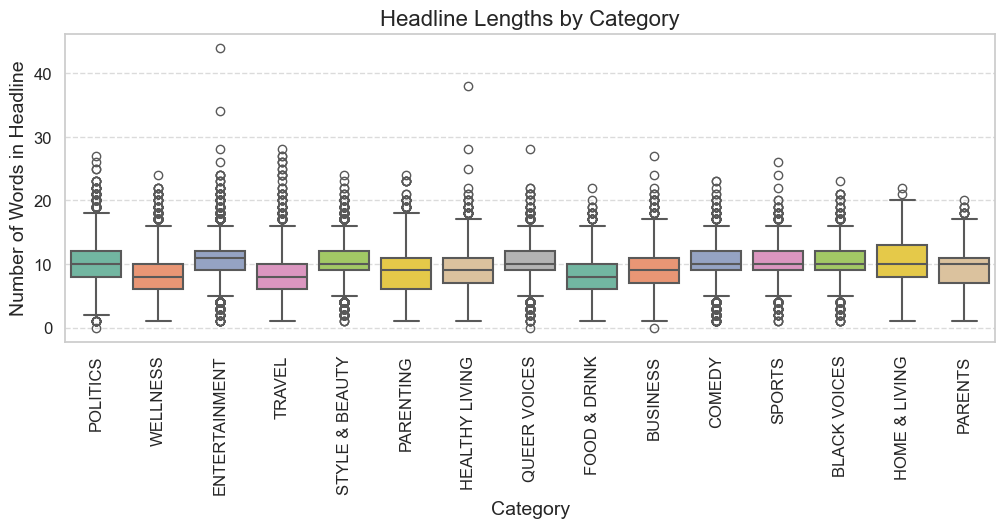

In [12]:
# Box plot of headline lengths by category with enhanced aesthetics
plt.figure(figsize=(12, 4))
sns.boxplot(x='category', y='headline_length', data=df_top15, order=df_top15['category'].value_counts().index, 
            palette="Set2", linewidth=1.5)
plt.xticks(rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.title('Headline Lengths by Category', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Words in Headline', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

- The above plots show the length of headlines. "Home & Living", "Entertainment", "Style & Beauty" have the longest headline lengths lengths out of all categories.

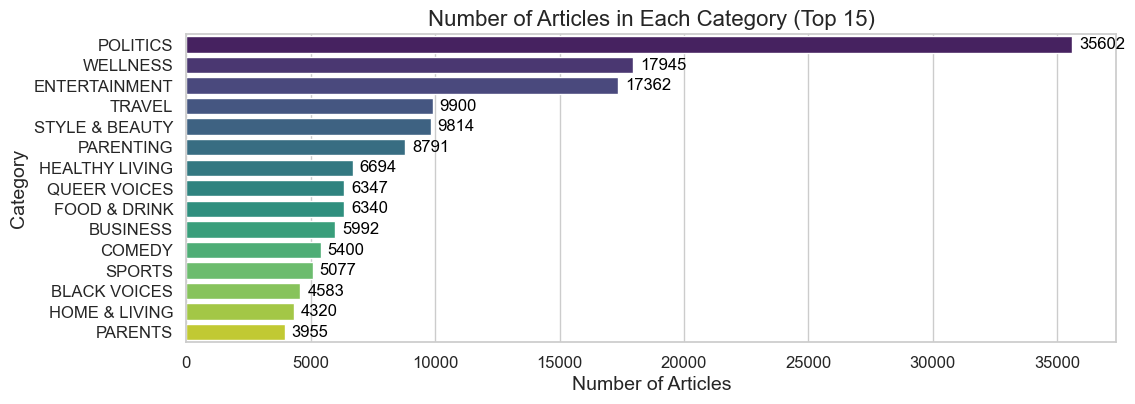

In [13]:
# Code-Block to see number of categories for each classes
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style
sns.set(style="whitegrid")

# Count of articles in each category
plt.figure(figsize=(12, 4))
ax = sns.countplot(y='category', data=df_top15, order=df_top15['category'].value_counts().index, palette="viridis")

# Adding the count labels on the bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', fontsize=12, color='black', 
                xytext=(5, 0),  # Offset to avoid overlap
                textcoords='offset points')

plt.title('Number of Articles in Each Category (Top 15)', fontsize=16)
plt.xlabel('Number of Articles', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- As seen earlier, "Politics" dominate in the number of published articles. While "Parents" and "Home & Leaving" contains the least amount of data.
- There are two seperate categories for "PARENTS" and "PARENTING". We can check for similarity among classes to see how they differ or whether they can be combined to create a better model.
- For now, we will stick to 15 categories as per the task.

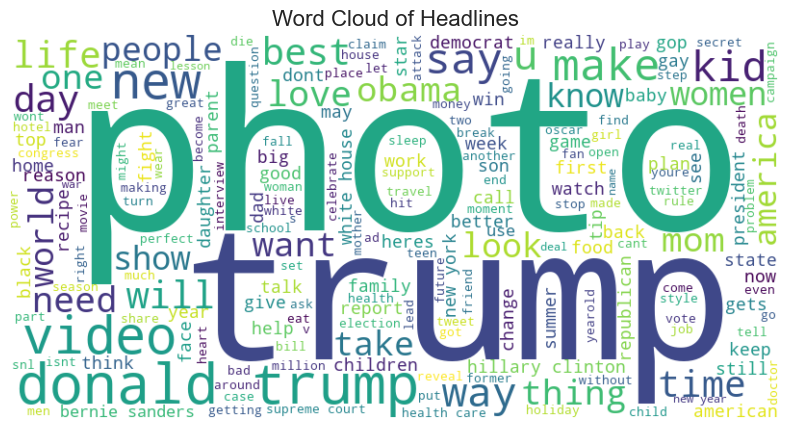

In [14]:
# Code cell to create a word-cloud(most common,all categories)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import re

# If the cleaned_headline column doesn't exist, create it first
def clean_headline(headline):
    # Clean the headline text
    return ' '.join(re.sub(r'[^A-Za-z\s]', '', headline).lower().split())

# Create the cleaned_headline column if it doesn't exist
if 'cleaned_headline' not in df_top15.columns:
    df_top15['cleaned_headline'] = df_top15['headline'].apply(clean_headline)

# Combine all headlines into one string
all_headlines = ' '.join(df_top15['cleaned_headline'])

# Create a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis', 
                      random_state=42, max_words=200).generate(all_headlines)

# Plot the word cloud
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Headlines', fontsize=16)
plt.show()


- The above picture shows the most common words across all categories. The bigger the word the more it is used.
- 'Photo' and "Trump" are most common words across all categories. 

In [15]:
# Code cell to extract date and year from date-time column
if 'date' in df_top15.columns:
    df_top15['date'] = pd.to_datetime(df_top15['date'], errors='coerce')  # Convert to datetime
    df_top15['year'] = df_top15['date'].dt.year  # Extract the year
else:
    print("No 'date' column found in the dataset.")

year
2012    25027
2013    28439
2014    20820
2015    19193
2016    21528
2017    21076
2018     7276
2019      952
2020     1578
2021     1412
2022      821
Name: count, dtype: int64


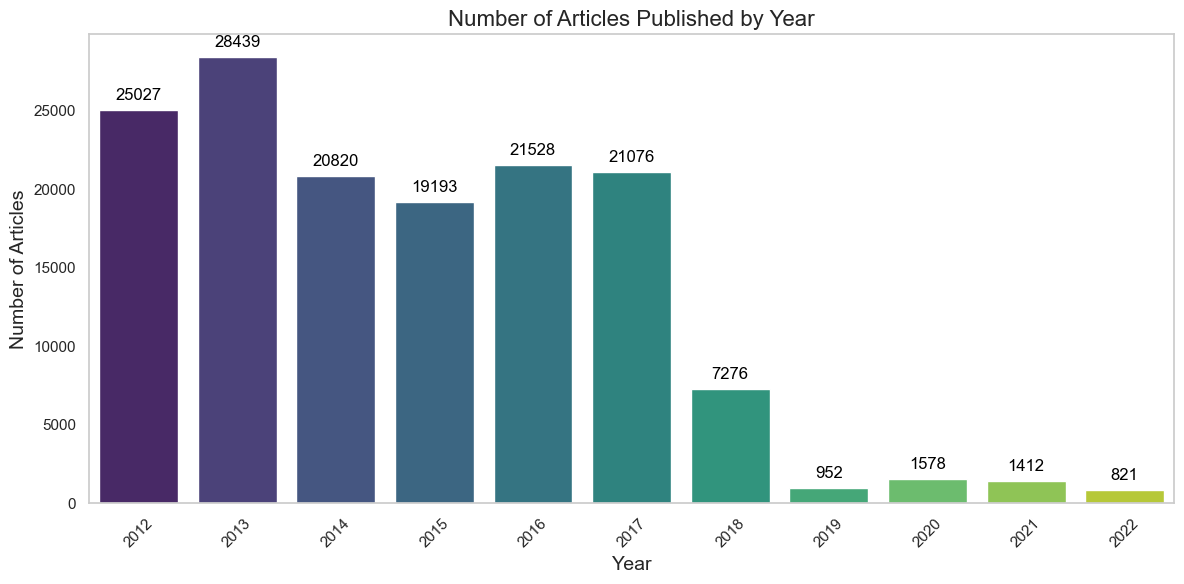

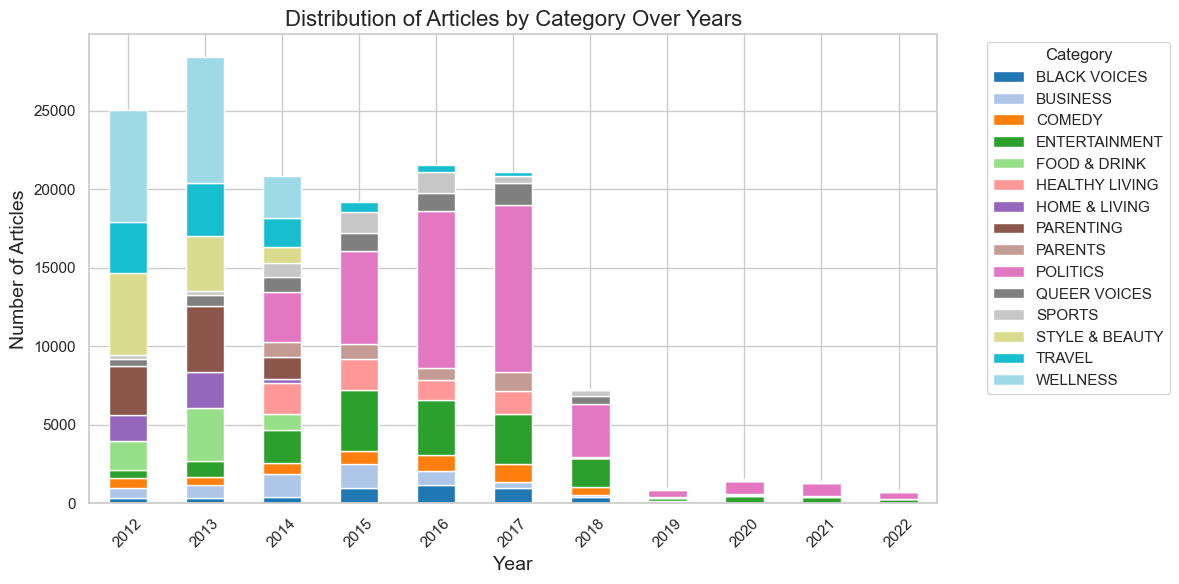

In [16]:
# Code cell to plot number of articles/year
import matplotlib.pyplot as plt
import seaborn as sns

# Check if 'year' is in the DataFrame
if 'year' in df_top15.columns:
    # Step 2: Count articles per year
    articles_per_year = df_top15['year'].value_counts().sort_index()
    print(articles_per_year)

    # Step 3: Plotting articles per year
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=articles_per_year.index, y=articles_per_year.values, palette='viridis')

    # Adding the number of articles on each bar
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2, p.get_height()), 
                    ha='center', va='bottom', fontsize=12, color='black', 
                    xytext=(0, 5),  # Offset to avoid overlap
                    textcoords='offset points')

    plt.title('Number of Articles Published by Year', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Articles', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

    # Step 4: Analyzing category distribution by year
    articles_per_year_category = df_top15.groupby(['year', 'category']).size().unstack()

    # Plotting the distribution of articles by category over the years
    plt.figure(figsize=(12, 6))
    articles_per_year_category.plot(kind='bar', stacked=True, colormap='tab20', ax=plt.gca())
    plt.title('Distribution of Articles by Category Over Years', fontsize=16)
    plt.xlabel('Year', fontsize=14)
    plt.ylabel('Number of Articles', fontsize=14)
    plt.xticks(rotation=45)
    plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("Year extraction failed. Check your DataFrame for date-related columns.")


- "Wellness" was the dominant class for year '2012' and '2013'. Eversince 'Politics' have overtaken to be the dominant class.
- The trend of politics being the dominant class hasn't changed since 2014

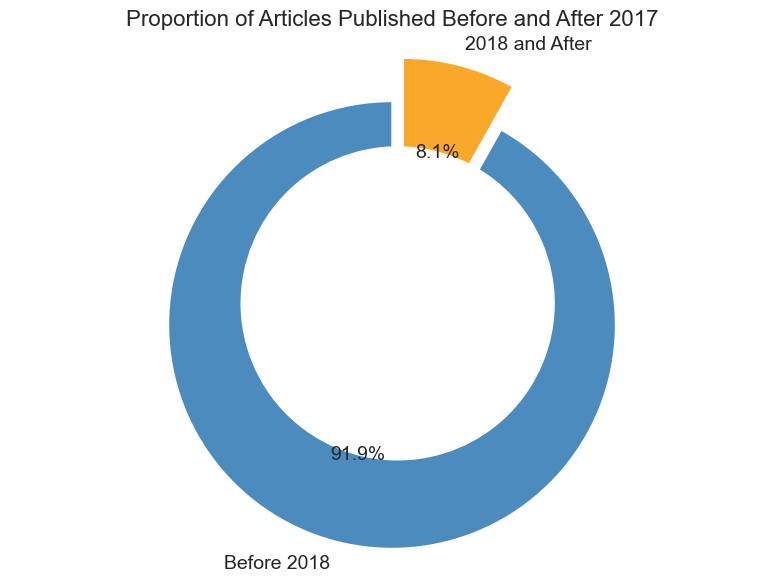

In [17]:
# Code cell to plot data distribution before 2018
import matplotlib.pyplot as plt

# Assuming 'year' is a column in df_top15
cutoff_year = 2017

# Step 1: Filter the data
before_cutoff = df_top15[df_top15['year'] <= cutoff_year]
after_cutoff = df_top15[df_top15['year'] > cutoff_year]

# Step 2: Calculate the proportions
count_before = before_cutoff.shape[0]
count_after = after_cutoff.shape[0]
total_count = df_top15.shape[0]

# Proportions for each category
proportions = [count_before / total_count, count_after / total_count]
labels = ['Before 2018', '2018 and After']

# Define a more harmonious color palette
colors = ['#4B8BBE', '#F9A828']  # A soft blue and warm gold

# Step 3: Plot the proportions
plt.figure(figsize=(8, 6))
explode = (0.1, 0.1)  # Slightly explode both slices for a 3D effect
plt.pie(proportions, labels=labels, autopct='%1.1f%%', startangle=90, 
        colors=colors, textprops={'fontsize': 14}, explode=explode)

# Adding a circle at the center to create a donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title(f'Proportion of Articles Published Before and After {cutoff_year}', fontsize=16)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()  # Adjust layout to fit the title
plt.show()

- 91.9% of the data exists before 2018. 

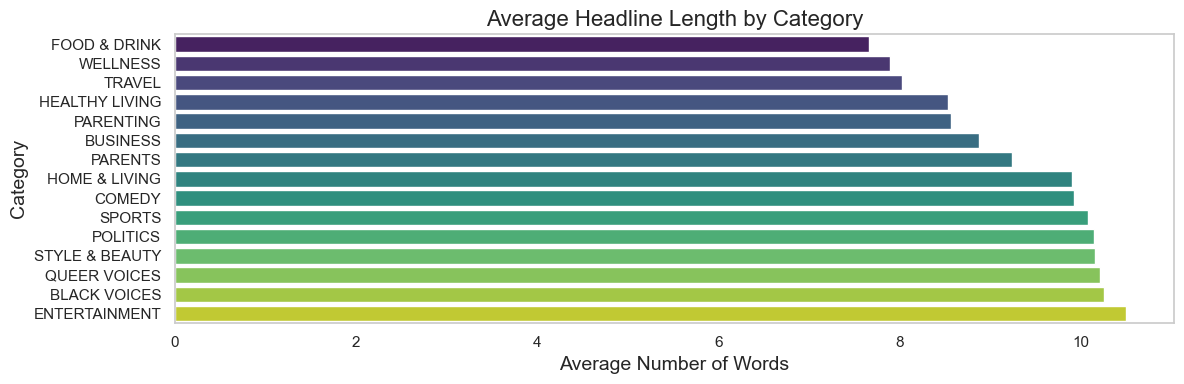

In [18]:
# Code cell to plot the average headline length per category
df_top15['headline_length'] = df_top15['cleaned_headline'].apply(lambda x: len(x.split()))
avg_headline_length = df_top15.groupby('category')['headline_length'].mean().sort_values()

# Plotting average headline lengths by category
plt.figure(figsize=(12, 4))
sns.barplot(x=avg_headline_length.values, y=avg_headline_length.index, palette='viridis')
plt.title('Average Headline Length by Category', fontsize=16)
plt.xlabel('Average Number of Words', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

- The above plot shows the average number of words for each category. "Entertainment" having the largest length while "Food & Drink" the least.

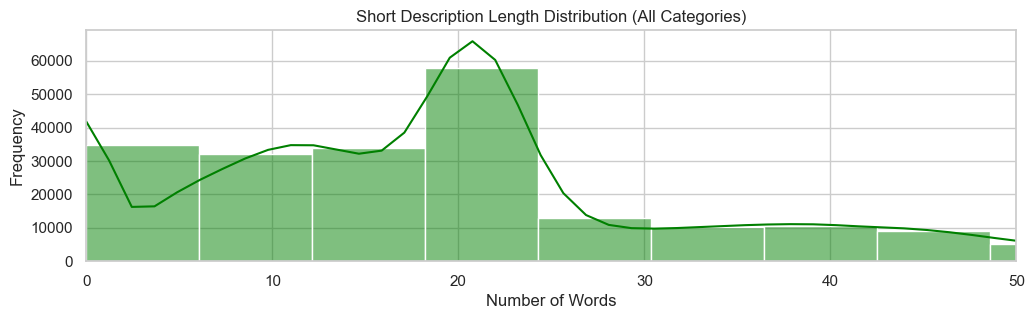

In [19]:
# Code cell to plot length of short description
df['short_description_len'] = df['short_description'].apply(lambda x: len(x.split()))

# Plotting short description length distribution for all categories
plt.figure(figsize=(12, 3))
sns.histplot(df['short_description_len'], bins=40, kde=True, color='green')
plt.title('Short Description Length Distribution (All Categories)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.xlim(0, 50)  # Adjust x-axis limits if necessary
plt.show()

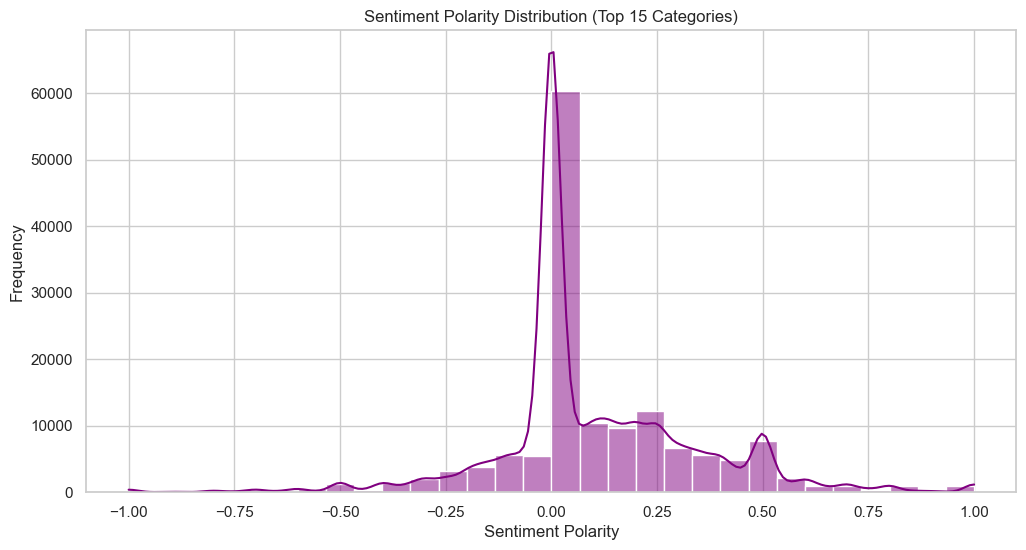

In [20]:
# Code cell  for applying sentiment analysis using TextBlob on the short descriptions (top 15 categories)
df_top15['sentiment'] = df_top15['short_description'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plotting sentiment distribution (top 15 categories)
plt.figure(figsize=(12,6))
sns.histplot(df_top15['sentiment'], bins=30, kde=True, color='purple')
plt.title('Sentiment Polarity Distribution (Top 15 Categories)')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

- Overall, when all categories combined, the average lies at a neutral sentiment. We can check this for each category.

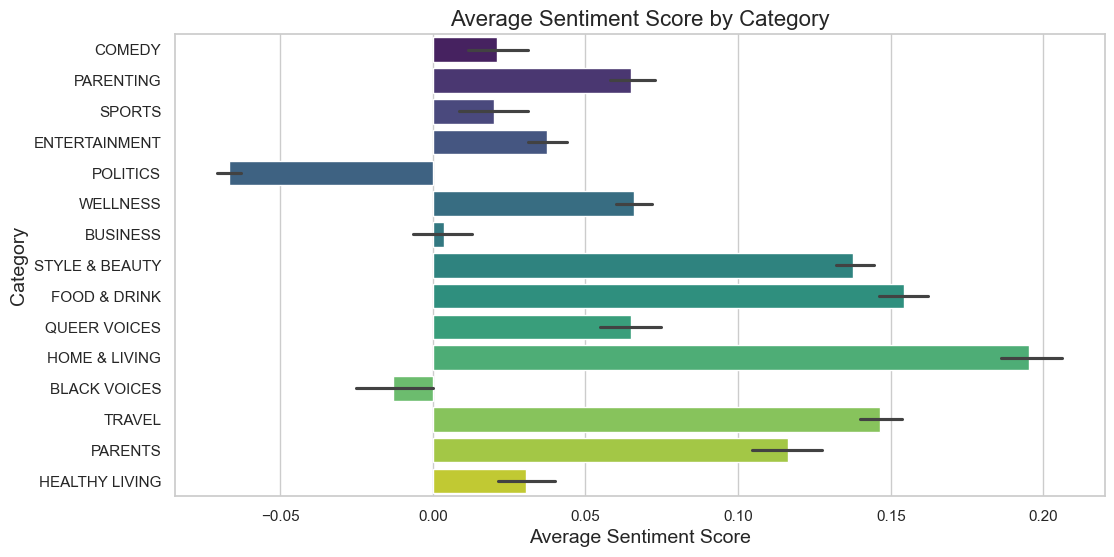

In [21]:
# Code cell to check sentiment by each category
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to calculate sentiment scores
def sentiment_analysis(headline):
    return analyzer.polarity_scores(headline)['compound']

# Apply sentiment analysis to the headlines
df_top15['sentiment'] = df_top15['cleaned_headline'].apply(sentiment_analysis)

# Plotting the average sentiment by category
plt.figure(figsize=(12, 6))
sns.barplot(x='sentiment', y='category', data=df_top15, estimator=np.mean, palette='viridis')
plt.title('Average Sentiment Score by Category', fontsize=16)
plt.xlabel('Average Sentiment Score', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()

- While the score remains close to neutral for every category. "Politics" has leaned towards negative just by a tiny bit.
- LifeStyle categories like "Politics", "Style & Beauty", "Home & Living" lean towards the positive score. 

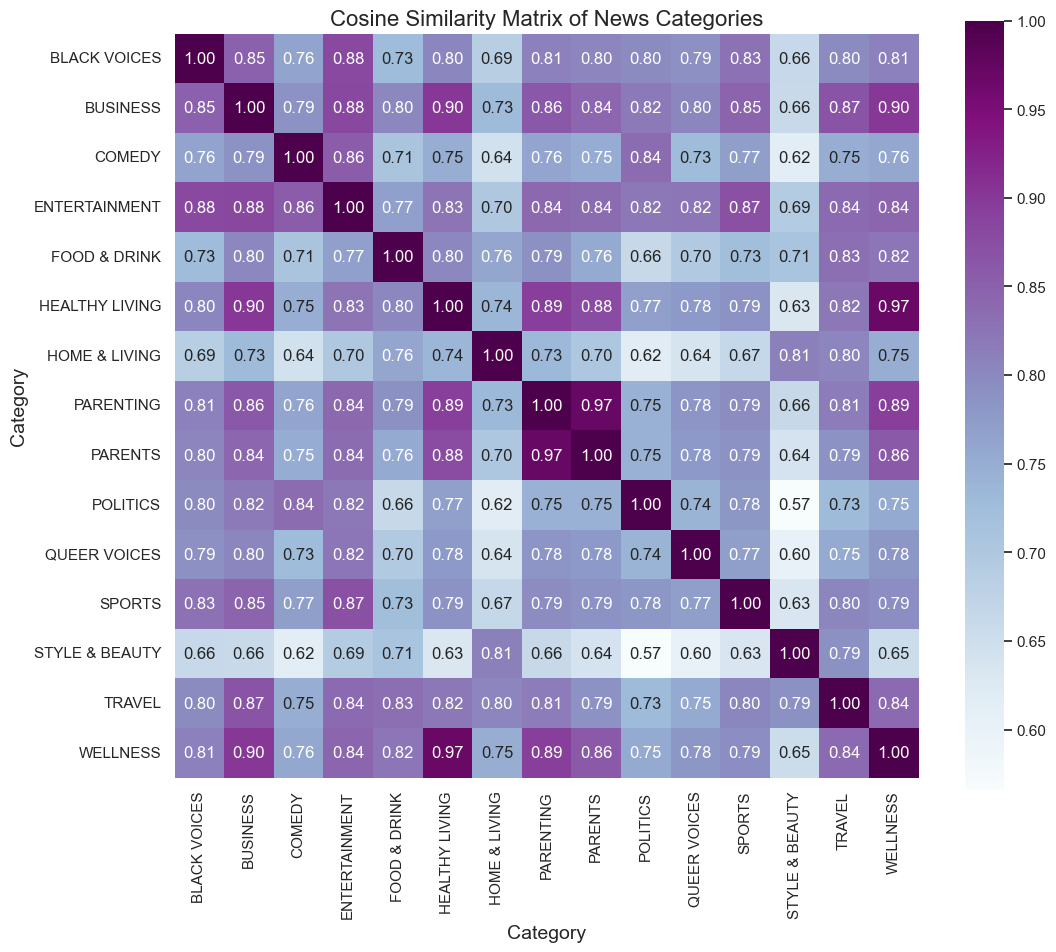

In [24]:
# Code cell to plot cosine Similarity Matrix of classes
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_top15 is already defined and contains 'cleaned_headline' and 'category'

# Group headlines by category and combine them
grouped_headlines = df_top15.groupby('category')['cleaned_headline'].apply(lambda x: ' '.join(x)).reset_index()

# Use TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(grouped_headlines['cleaned_headline'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix)

# Create a DataFrame for the cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=grouped_headlines['category'], columns=grouped_headlines['category'])

# Plotting the cosine similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cosine_sim_df, annot=True, fmt=".2f", cmap='BuPu', square=True)
plt.title('Cosine Similarity Matrix of News Categories', fontsize=16)
plt.xlabel('Category', fontsize=14)
plt.ylabel('Category', fontsize=14)
plt.show()

- "Wellness" and "Healthy Living" are extremely similar having a 0.97 cosine similarity.
- As suspected before "Parents" and "Parenting" also have 0.97 cosine similarity. 

### These categories can be combined in best models for a more tailored approach which can help in increasing the accuracy metrics that we will decide.   


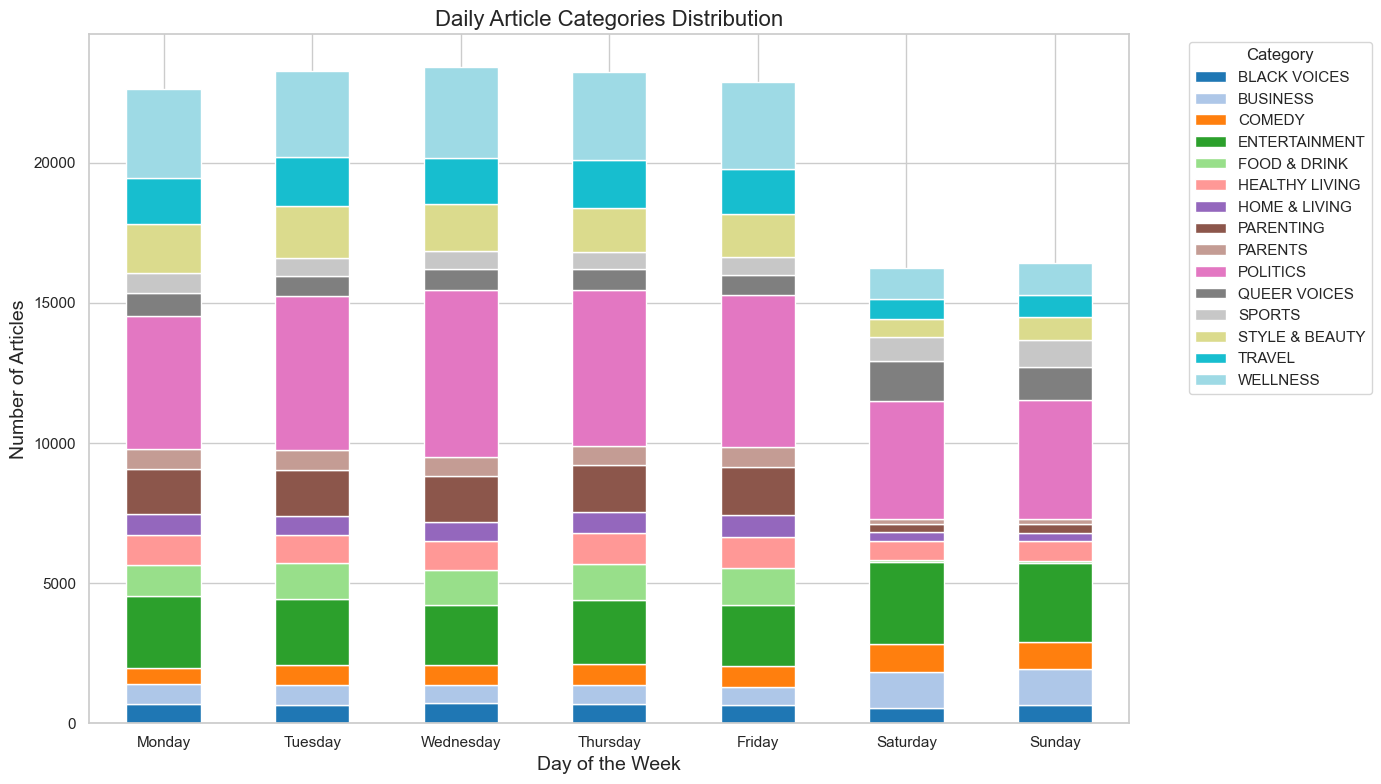

In [33]:
# Code cell to plot day by day distribution of dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'date' is a column in df_top15 that holds the publication date
# Step 1: Convert 'date' to datetime and create a new column for the day
df_top15['date'] = pd.to_datetime(df_top15['date'])  # Ensure your date column is in datetime format
df_top15['day'] = df_top15['date'].dt.day_name()  # Get the day name

# Step 2: Group the data by day and category, and count the number of articles
daily_category_counts = df_top15.groupby(['day', 'category']).size().unstack(fill_value=0)

# Step 3: Sort the index to ensure days of the week are in order
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_category_counts = daily_category_counts.reindex(day_order)

# Step 4: Plot the data
plt.figure(figsize=(14, 8))
daily_category_counts.plot(kind='bar', stacked=True, colormap='tab20', ax=plt.gca())
plt.title('Daily Article Categories Distribution', fontsize=16)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


- The above plot shows the day by day distribution of the categories. 
- The articles are mainly focused on 'Politics', "Entertainment" and "Business".

# Data Preprocessing 
- This section prepares the data for modeling by cleaning and transforming the text. 
- It'll address missing values, remove HTML tags and special characters, and normalize(lower-case) text.
- Stop-words removal and lemmatization to standardize word forms. 

In [31]:
# Code cell to clean the data 
import nltk
import re

# Create a custom directory in /kaggle/working for storing NLTK data
nltk_data_dir = '/kaggle/working/nltk_data'

# If the directory doesn't exist, create it
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Append the custom directory to the NLTK data path
nltk.data.path.append(nltk_data_dir)

# Download the necessary resources to the custom directory
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)  # Support for WordNet

# Proceed with NLTK usage as usual
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords and lemmatize words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    
    return text

# Assuming df is your DataFrame with 'headline' and 'short_description' columns
df['cleaned_headline'] = df['headline'].apply(clean_text)
df['cleaned_description'] = df['short_description'].apply(lambda x: clean_text(str(x)))

# Check the cleaned data
df[['cleaned_headline', 'cleaned_description']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,cleaned_headline,cleaned_description
0,4 million american roll sleeve omicrontargeted...,health expert said early predict whether deman...
1,american airline flyer charged banned life pun...,subdued passenger crew fled back aircraft conf...
2,23 funniest tweet cat dog week sept 1723,dog dont understand could eaten
3,funniest tweet parent week sept 1723,accidentally put grownup toothpaste toddler to...
4,woman called cop black birdwatcher loses lawsu...,amy cooper accused investment firm franklin te...


- Created two new dataframes to test models with and without stop words.
- Lemmatized all the words as it preserves the meaning and grammatical function of the words. 
- tokenized and normalized the words.     

In [65]:
# Code cell to print dataset with stopwords
print("Dataset with stopwords:")
df_with_stopwords.head()

Dataset with stopwords:


,headline,category
0,over 4 million american roll up sleeve for omi...,U.S. NEWS
1,american airline flyer charged banned for life...,U.S. NEWS
2,23 of the funniest tweet about cat and dog thi...,COMEDY
3,the funniest tweet from parent this week sept ...,PARENTING
4,woman who called cop on black birdwatcher lose...,U.S. NEWS


In [67]:
# code cell to print dataset without stopwords
print("\nDataset without stopwords:")
df_no_stopwords.head()



Dataset without stopwords:


,headline,category
0,4 million american roll sleeve omicrontargeted...,U.S. NEWS
1,american airline flyer charged banned life pun...,U.S. NEWS
2,23 funniest tweet cat dog week sept 1723,COMEDY
3,funniest tweet parent week sept 1723,PARENTING
4,woman called cop black birdwatcher loses lawsu...,U.S. NEWS


In [68]:
# Top 15 categories in dataset without stopwords
top_categories_no_stopwords = df_no_stopwords['category'].value_counts().nlargest(15)

# Top 15 categories in dataset with stopwords
top_categories_with_stopwords = df_with_stopwords['category'].value_counts().nlargest(15)

- Made a list of top 15 categories to filter the datasets accordingly.

In [71]:
# Top 15 categories
print("Top 15 Categories")
top_categories_no_stopwords

Top 15 Categories


category
POLITICS          35602
WELLNESS          17945
ENTERTAINMENT     17362
TRAVEL             9900
STYLE & BEAUTY     9814
PARENTING          8791
HEALTHY LIVING     6694
QUEER VOICES       6347
FOOD & DRINK       6340
BUSINESS           5992
COMEDY             5400
SPORTS             5077
BLACK VOICES       4583
HOME & LIVING      4320
PARENTS            3955
Name: count, dtype: int64

In [72]:
# Filtering the datasets
df_no_stopwords_filtered = df_no_stopwords[df_no_stopwords['category'].isin(top_categories_no_stopwords.index)]
df_with_stopwords_filtered = df_with_stopwords[df_with_stopwords['category'].isin(top_categories_with_stopwords.index)]

# Shapes of the filtered datasets
print("Filtered dataset without stopwords shape:", df_no_stopwords_filtered.shape)
print("Filtered dataset with stopwords shape:", df_with_stopwords_filtered.shape)


Filtered dataset without stopwords shape: (148122, 2)

Filtered dataset with stopwords shape: (148122, 2)


# Train-Test Split
- Here we split the data into X and Y for both the datasets.
- Train_test_split on X and Y. 

In [73]:
# Separate features and labels
X_no_stopwords = df_no_stopwords_filtered['headline']
y_no_stopwords = df_no_stopwords_filtered['category']

X_with_stopwords = df_with_stopwords_filtered['headline']
y_with_stopwords = df_with_stopwords_filtered['category']


In [74]:
from sklearn.model_selection import train_test_split

# Stratified train-test split for dataset without stopwords
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    X_no_stopwords, y_no_stopwords, test_size=0.2, random_state=42, stratify=y_no_stopwords
)

# Stratified train-test split for dataset with stopwords
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(
    X_with_stopwords, y_with_stopwords, test_size=0.2, random_state=42, stratify=y_with_stopwords
)

# Shapes of the split datasets
print("Shapes for dataset without stopwords - X_train:", X_train_no.shape, "y_train:", y_train_no.shape)
print("Shapes for dataset without stopwords - X_test:", X_test_no.shape, "y_test:", y_test_no.shape)

print("Shapes for dataset with stopwords - X_train:", X_train_with.shape, "y_train:", y_train_with.shape)
print("Shapes for dataset with stopwords - X_test:", X_test_with.shape, "y_test:", y_test_with.shape)


Shapes for dataset without stopwords - X_train: (118497,) y_train: (118497,)

Shapes for dataset without stopwords - X_test: (29625,) y_test: (29625,)

Shapes for dataset with stopwords - X_train: (118497,) y_train: (118497,)

Shapes for dataset with stopwords - X_test: (29625,) y_test: (29625,)


- We stratified the split due to class imbalance. It ensure the that original proportion of different classes remain the same in validation dataset and the model accuracy doesn't depend on 'luck' if validation data contains mostly the highest proportion category. 

# 4.3 TF-IDF Vectorization
**Note**: Various combinations of n-grams were tested; however, only the optimal solutions are showcased in this notebook.
**Note**: As noted earlier more tailored approach can also be used by combining similar categories which are later tested in the best models.

In [76]:
# Using tf-idf vectorization to 
from sklearn.feature_extraction.text import TfidfVectorizer

# Function to create TF-IDF vectorizer
def create_tfidf_vectorizer(n_gram_range=(1, 1)):
    vectorizer = TfidfVectorizer(ngram_range=n_gram_range)
    return vectorizer

# TF-IDF Vectorization for dataset without stopwords
tfidf_vectorizer_no = create_tfidf_vectorizer(n_gram_range=(1, 1))  # Unigram
X_train_no_tfidf = tfidf_vectorizer_no.fit_transform(X_train_no)
X_test_no_tfidf = tfidf_vectorizer_no.transform(X_test_no)

# TF-IDF Vectorization for dataset with stopwords
tfidf_vectorizer_with = create_tfidf_vectorizer(n_gram_range=(1, 1))  # Unigram
X_train_with_tfidf = tfidf_vectorizer_with.fit_transform(X_train_with)
X_test_with_tfidf = tfidf_vectorizer_with.transform(X_test_with)

# Optional: Check the shape of the TF-IDF matrices
print("TF-IDF shape for training dataset without stopwords:", X_train_no_tfidf.shape)
print("TF-IDF shape for testing dataset without stopwords:", X_test_no_tfidf.shape)

print("TF-IDF shape for training dataset with stopwords:", X_train_with_tfidf.shape)
print("TF-IDF shape for testing dataset with stopwords:", X_test_with_tfidf.shape)


TF-IDF shape for training dataset without stopwords: (118497, 45457)

TF-IDF shape for testing dataset without stopwords: (29625, 45457)

TF-IDF shape for training dataset with stopwords: (118497, 45563)

TF-IDF shape for testing dataset with stopwords: (29625, 45563)


- With this we're done with data pre-processing. 
- 2 datasets have been created (with and without stop-words for testing).
- Appropriate data-preprocessing steps have been used like normalizing, removing tags and special characters. 

# 5. Traditional Machine Learning Models
- In this section, we explored two models: Naive Bayes and Logistic Regression. Both models were evaluated using k-fold cross-validation to ensure robust validation of their performance.

**Note**: The models were also tested with different n-gram configurations in the TF-IDF vectorizer. However, the models showcased here utilized unigrams, as they consistently outperformed other n-gram configurations.

Feature engineering. Creating new features like "best_category_each_year", "Most_common_word", "most_common_word_majority_class" were also tested which only caused to model to overfit and perform poorly. 

Training with engineered features and multiple features was too computationally expensive, while we tried out on different models, 
It was overfitting on the train dataset and performing poorly while validation. "Headline" was selected as the independent feature where the model was performing modestly for all the classes.

 Undersampling the majority classes caused the accuracy and the minority classes also showed lesser accuracy for traditional machine learning models. While oversampling was causing the model to overfit and decreased recall in almost every metric, again, for the traditional machine learning models.

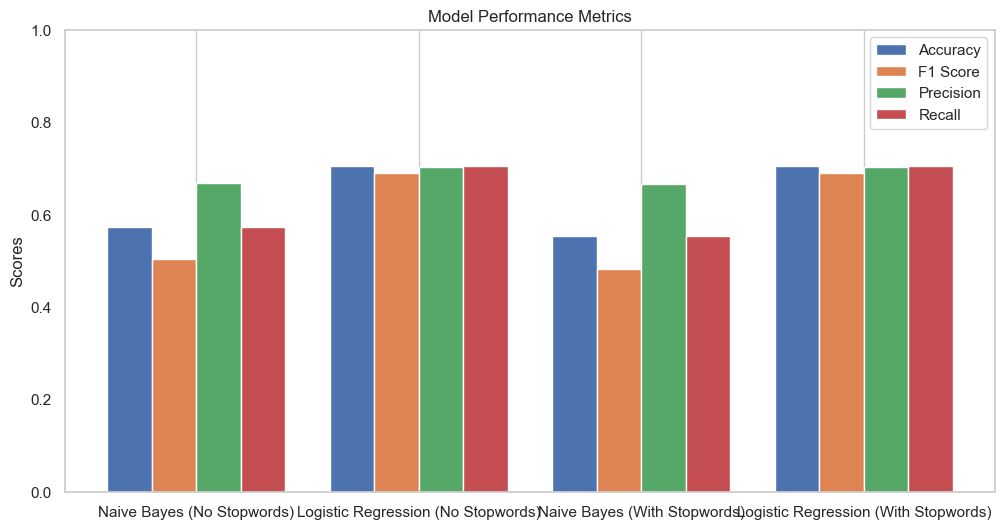

In [81]:
# Model Building
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Function to train and evaluate a model and return metrics and classification report
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model):
    # K-Fold Cross Validation
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)  # 5-fold cross-validation
    mean_cv_accuracy = np.mean(cv_scores)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    # Save the classification report as a dictionary
    report = classification_report(y_test, y_pred, output_dict=True)
    
    return accuracy, f1, precision, recall, report  # Return metrics and report


# Step 5: Train and evaluate models for dataset without stopwords
naive_bayes_metrics_no = train_and_evaluate_model(X_train_no_tfidf, y_train_no, X_test_no_tfidf, y_test_no, MultinomialNB())
logistic_regression_metrics_no = train_and_evaluate_model(X_train_no_tfidf, y_train_no, X_test_no_tfidf, y_test_no, LogisticRegression(max_iter=1000))

# Step 5: Train and evaluate models for dataset with stopwords
naive_bayes_metrics_with = train_and_evaluate_model(X_train_with_tfidf, y_train_with, X_test_with_tfidf, y_test_with, MultinomialNB())
logistic_regression_metrics_with = train_and_evaluate_model(X_train_with_tfidf, y_train_with, X_test_with_tfidf, y_test_with, LogisticRegression(max_iter=1000))

# Collect metrics for plotting
models = ['Naive Bayes (No Stopwords)', 'Logistic Regression (No Stopwords)',
          'Naive Bayes (With Stopwords)', 'Logistic Regression (With Stopwords)']

# Extract metrics for plotting
accuracies = [naive_bayes_metrics_no[0], logistic_regression_metrics_no[0],
              naive_bayes_metrics_with[0], logistic_regression_metrics_with[0]]
f1_scores = [naive_bayes_metrics_no[1], logistic_regression_metrics_no[1],
              naive_bayes_metrics_with[1], logistic_regression_metrics_with[1]]
precisions = [naive_bayes_metrics_no[2], logistic_regression_metrics_no[2],
               naive_bayes_metrics_with[2], logistic_regression_metrics_with[2]]
recalls = [naive_bayes_metrics_no[3], logistic_regression_metrics_no[3],
           naive_bayes_metrics_with[3], logistic_regression_metrics_with[3]]

# Plotting the metrics for each model
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width*1.5, accuracies, width, label='Accuracy')
bars2 = ax.bar(x - width/2, f1_scores, width, label='F1 Score')
bars3 = ax.bar(x + width/2, precisions, width, label='Precision')
bars4 = ax.bar(x + width*1.5, recalls, width, label='Recall')

# Adding labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.grid(axis='y')

# Show plot
plt.ylim(0, 1)  # Set y-axis limits to [0, 1] for better visualization
plt.show()

# Save classification reports for later use
classification_reports = {
    'Naive Bayes (No Stopwords)': naive_bayes_metrics_no[4],
    'Logistic Regression (No Stopwords)': logistic_regression_metrics_no[4],
    'Naive Bayes (With Stopwords)': naive_bayes_metrics_with[4],
    'Logistic Regression (With Stopwords)': logistic_regression_metrics_with[4],
}


In [83]:
# Classification reports for models
import pandas as pd

# Function to print classification report in tabular format
def print_classification_report(model_name, report):
    # Convert classification report to DataFrame
    report_df = pd.DataFrame(report).transpose()
    
    # Print model name
    print(f"Classification Report for {model_name}:\n")
    print(report_df[['precision', 'recall', 'f1-score', 'support']])
    print("\n")

# Display classification reports for each model
for model_name, report in classification_reports.items():
    print_classification_report(model_name, report)


Classification Report for Naive Bayes (No Stopwords):



                precision    recall  f1-score       support

BLACK VOICES     0.928571  0.014177  0.027927    917.000000

BUSINESS         0.895652  0.085977  0.156893   1198.000000

COMEDY           0.812500  0.036111  0.069149   1080.000000

ENTERTAINMENT    0.560025  0.777714  0.651157   3473.000000

FOOD & DRINK     0.886024  0.514984  0.651372   1268.000000

HEALTHY LIVING   0.714286  0.003734  0.007429   1339.000000

HOME & LIVING    0.934028  0.311343  0.467014    864.000000

PARENTING        0.589306  0.294653  0.392871   1758.000000

PARENTS          0.500000  0.002528  0.005031    791.000000

POLITICS         0.511958  0.983008  0.673271   7121.000000

QUEER VOICES     0.936893  0.152088  0.261695   1269.000000

SPORTS           0.910714  0.200985  0.329298   1015.000000

STYLE & BEAUTY   0.823163  0.673459  0.740824   1963.000000

TRAVEL           0.807018  0.604040  0.690930   1980.000000

WELLNESS         0.500272  0

- Logistic Regression (With Stopwords) is the best performing model with an accuracy of 70.5%. Since neural networks and models like Bert, Roberta, DistilBert are able to understand "context", and logistic regression(with stopwards) having better accuracy, moving ahead we will use the dataset with stop-words.
- It's also seen the that recall(True predicted out of all true samples) is significantly less for minority class. Introducing class weights may be able to solve this issue. 

# Introducing class weights
- Introducing class weights on best performing model to see if accuracy increases.

In [85]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Function to train and evaluate a model and return metrics and classification report
def train_and_evaluate_model(X_train, y_train, X_test, y_test, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Save the classification report as a dictionary
    report = classification_report(y_test, y_pred, output_dict=True)
    
    return report  # Return report

# Step 5: Train and evaluate a Logistic Regression model with class weights on the dataset with stopwords
logistic_regression_model = LogisticRegression(class_weight='balanced', max_iter=1000)  # Use balanced class weights
classification_report_with_weights = train_and_evaluate_model(
    X_train_with_tfidf, 
    y_train_with, 
    X_test_with_tfidf, 
    y_test_with, 
    logistic_regression_model
)

# Convert the classification report into a DataFrame for better display
report_df = pd.DataFrame(classification_report_with_weights).transpose()

# Display the classification report
print(report_df)


                precision    recall  f1-score       support

BLACK VOICES     0.425685  0.643402  0.512375    917.000000

BUSINESS         0.485594  0.675292  0.564944   1198.000000

COMEDY           0.474002  0.582407  0.522642   1080.000000

ENTERTAINMENT    0.759762  0.661100  0.707005   3473.000000

FOOD & DRINK     0.721501  0.788644  0.753580   1268.000000

HEALTHY LIVING   0.294684  0.434653  0.351237   1339.000000

HOME & LIVING    0.669931  0.791667  0.725729    864.000000

PARENTING        0.567823  0.511945  0.538439   1758.000000

PARENTS          0.346189  0.476612  0.401064    791.000000

POLITICS         0.919475  0.747227  0.824450   7121.000000

QUEER VOICES     0.733923  0.719464  0.726622   1269.000000

SPORTS           0.668305  0.803941  0.729875   1015.000000

STYLE & BEAUTY   0.816834  0.786042  0.801142   1963.000000

TRAVEL           0.758687  0.793939  0.775913   1980.000000

WELLNESS         0.668359  0.550293  0.603606   3589.000000

accuracy         0.67534

Comparison of Classification Reports
1. Minority Classes Performance:

BLACK VOICES:

- Precision: 0.661 → 0.426
- Recall: 0.383 → 0.643
- F1-Score: 0.485 → 0.512

BUSINESS:

- Precision: 0.689 → 0.486
- Recall: 0.470 → 0.675
- F1-Score: 0.559 → 0.565

COMEDY:

- Precision: 0.681 → 0.474
- Recall: 0.436 → 0.582
- F1-Score: 0.532 → 0.523

HEALTHY LIVING:

- Precision: 0.465 → 0.295
- Recall: 0.168 → 0.435
- F1-Score: 0.247 → 0.351

PARENTS:

- Precision: 0.555 → 0.346
- Recall: 0.210 → 0.477
- F1-Score: 0.305 → 0.401

2. Majority Classes Performance:

ENTERTAINMENT:

- Precision: 0.676 → 0.760
- Recall: 0.785 → 0.661
- F1-Score: 0.727 → 0.707

POLITICS:

- Precision: 0.777 → 0.919
- Recall: 0.908 → 0.747
- F1-Score: 0.838 → 0.824

FOOD & DRINK:

- Precision: 0.800 → 0.722
- Recall: 0.722 → 0.789
- F1-Score: 0.759 → 0.754

3. Summary:

Minority Classes: Using class_weight='balanced' improved recall significantly for most minority classes, enhancing their identification. However, precision dropped for several, resulting in mixed F1-scores. Overall, F1-scores improved for BLACK VOICES, BUSINESS, and HEALTHY LIVING.

Majority Classes: Most majority classes maintained high precision, with slight decreases in recall. Overall performance did not significantly decline, as shown in the weighted averages.

Overall Performance: Accuracy decreased from 70.6% to 67.5% with the introduction of class weights, indicating better handling of class imbalances, despite a slight drop in overall accuracy. This suggests that class weights may improve the model's performance in applications involving imbalanced datasets.

Assuming that more number are articles are from the majority classes, we can use the model without weights introduced. In the other case, we can most certainly use the model created using weights. 

# 6. Deep Learning Approach

### In this section, we will train Bi-Directional Long Short-Term Memory(Bi-LSTM) model for text classification

- Since the model processes input in both forward and backward directions, capturing context from both past and future.
- Long-Term Dependencies: Effectively remembers relationships in sequences, enhancing comprehension of language nuances.

- Robustness: Handles noisy data well by leveraging information from both directions.

- Flexibility: Supports stacking of layers for deeper networks, improving performance on complex classification tasks.

In [37]:
# Cleaning the text from the start.
import os
import nltk
import re

# Create a custom directory in /kaggle/working for storing NLTK data
nltk_data_dir = '/kaggle/working/nltk_data'

# If the directory doesn't exist, create it
if not os.path.exists(nltk_data_dir):
    os.makedirs(nltk_data_dir)

# Append the custom directory to the NLTK data path
nltk.data.path.append(nltk_data_dir)

# Download the necessary resources to the custom directory
nltk.download('stopwords', download_dir=nltk_data_dir)
nltk.download('wordnet', download_dir=nltk_data_dir)
nltk.download('omw-1.4', download_dir=nltk_data_dir)  # Support for WordNet

# Proceed with NLTK usage as usual
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove HTML tags and special characters
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[^\w\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    return text

# Assuming df is your DataFrame with 'headline' and 'short_description' columns
df['cleaned_headline'] = df['headline'].apply(clean_text)
df['cleaned_description'] = df['short_description'].apply(lambda x: clean_text(str(x)))

# Check the cleaned data
df[['cleaned_headline', 'cleaned_description']].head()

[nltk_data] Downloading package stopwords to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,cleaned_headline,cleaned_description
0,over 4 million american roll up sleeve for omi...,health expert said it is too early to predict ...
1,american airline flyer charged banned for life...,he wa subdued by passenger and crew when he fl...
2,23 of the funniest tweet about cat and dog thi...,until you have a dog you dont understand what ...
3,the funniest tweet from parent this week sept ...,accidentally put grownup toothpaste on my todd...
4,woman who called cop on black birdwatcher lose...,amy cooper accused investment firm franklin te...


In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming `filtered_df` contains your cleaned text data
X = filtered_df['cleaned_headline'] + " " + filtered_df['cleaned_description']  # Combine text features
y = filtered_df['category']  # Target variable

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42)



In [49]:
# Code cell for tokenization, Label encoder and train test split
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader

# Assuming you have a filtered DataFrame called filtered_df

# Tokenize and encode the headlines using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)  # Limit to the top 10000 words
X_vectorized = vectorizer.fit_transform(filtered_df['headline']).toarray()

# Label encode the target variable (categories)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(filtered_df['category'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y_encoded, test_size=0.2, random_state=42)

# Check the shapes of the training and testing sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (118497, 10000), y_train shape: (118497,)
X_test shape: (29625, 10000), y_test shape: (29625,)


In [50]:
# importing libraries and Dataloader for training
import torch
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        # Return the input as LongTensor and the target as LongTensor
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

# Create datasets
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [54]:
# code cell for introducing class_weights
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weights = torch.tensor(class_weights, dtype=torch.float32)  # Convert to tensor


In [56]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from torch.utils.data import Dataset, DataLoader
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Bi-LSTM Model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(BiLSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        x, _ = self.lstm(x)  # LSTM output
        x = x[:, -1, :]  # Get the last output of the LSTM
        x = self.fc(x)  # Fully connected layer
        return x

# Model, Loss, Optimizer, Scheduler
input_dim = X_vectorized.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y_train))
model = BiLSTMModel(input_dim, hidden_dim, output_dim).to(device)  # Move model to GPU

# Use class weights in CrossEntropyLoss
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Early stopping setup
patience = 5
best_loss = float('inf')
early_stopping_counter = 0

# Training Loop
num_epochs = 15
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == y_batch).sum().item()
        total_samples += y_batch.size(0)

    avg_loss = total_loss / len(train_loader)
    accuracy = total_correct / total_samples
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Step the scheduler
    scheduler.step()

    # Early stopping check
    if avg_loss < best_loss:
        best_loss = avg_loss
        early_stopping_counter = 0  # Reset counter
        print("Model improved, saving model...")
    else:
        early_stopping_counter += 1

    if early_stopping_counter >= patience:
        print("Early stopping triggered.")
        break

# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        y_pred.extend(predicted.cpu().numpy())  # Move to CPU for compatibility
        y_true.extend(y_batch.cpu().numpy())

# Classification report
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Additional metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
precision = precision_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Precision: {precision:.4f}")


Epoch 1/15, Loss: 1.3805, Accuracy: 0.5969
Model improved, saving model...
Epoch 2/15, Loss: 0.9896, Accuracy: 0.6792
Model improved, saving model...
Epoch 3/15, Loss: 0.8620, Accuracy: 0.7098
Model improved, saving model...
Epoch 4/15, Loss: 0.7373, Accuracy: 0.7440
Model improved, saving model...
Epoch 5/15, Loss: 0.6132, Accuracy: 0.7819
Model improved, saving model...
Epoch 6/15, Loss: 0.4537, Accuracy: 0.8421
Model improved, saving model...
Epoch 7/15, Loss: 0.4342, Accuracy: 0.8489
Model improved, saving model...
Epoch 8/15, Loss: 0.4174, Accuracy: 0.8538
Model improved, saving model...
Epoch 9/15, Loss: 0.4025, Accuracy: 0.8591
Model improved, saving model...
Epoch 10/15, Loss: 0.3885, Accuracy: 0.8640
Model improved, saving model...
Epoch 11/15, Loss: 0.3725, Accuracy: 0.8710
Model improved, saving model...
Epoch 12/15, Loss: 0.3702, Accuracy: 0.8715
Model improved, saving model...
Epoch 13/15, Loss: 0.3687, Accuracy: 0.8720
Model improved, saving model...
Epoch 14/15, Loss: 0.

In [34]:
# Code cell for creating model comparison dataframe
import pandas as pd

# Define data for comparison
data = {
    "Aspect": [
        "Model Type",
        "Framework",
        "Embedding Layer",
        "Hidden Units",
        "Dropout",
        "Output Layer",
        "Loss Function",
        "Optimizer",
        "Accuracy",
        "Precision (Weighted Avg)",
        "Recall (Weighted Avg)",
        "F1 Score (Weighted Avg)",
        "Strengths",
        "Weaknesses"
    ],
    "First Bi-LSTM Model (Keras)": [
        "Bi-LSTM",
        "Keras",
        "Embedding layer (input_dim=5000, output_dim=128)",
        "128",
        "Dropout: 0.2, Recurrent Dropout: 0.2",
        "Dense layer with 15 categories (softmax)",
        "Sparse Categorical Crossentropy",
        "Adam",
        "0.6874",
        "0.68",
        "0.69",
        "0.68",
        "Strong performance in 'Politics' and 'Food & Drink'",
        "Struggles with 'Healthy Living' (precision: 0.38, recall: 0.18)"
    ],
    "Second Bi-LSTM Model (PyTorch)": [
        "Bi-LSTM",
        "PyTorch",
        "No explicit embedding layer (input_dim matches vectorized input)",
        "64 (bidirectional)",
        "Not specified",
        "Fully connected layer with num_labels (15)",
        "CrossEntropyLoss with class weights",
        "Adam",
        "0.6597",
        "0.6730",
        "0.66",
        "0.6648",
        "Strong performance in 'Politics' and 'Style & Beauty'",
        "Lower overall accuracy; struggles with 'Healthy Living' (precision: 0.29, recall: 0.36)"
    ]
}

# Create DataFrame
comparison_df = pd.DataFrame(data)

# Display the DataFrame
comparison_df


,Aspect,First Bi-LSTM Model (Keras),Second Bi-LSTM Model (PyTorch)
0,Model Type,Bi-LSTM,Bi-LSTM
1,Framework,Keras,PyTorch
2,Embedding Layer,"Embedding layer (input_dim=5000, output_dim=128)",No explicit embedding layer (input_dim matches...
3,Hidden Units,128,64 (bidirectional)
4,Dropout,"Dropout: 0.2, Recurrent Dropout: 0.2",Not specified
5,Output Layer,Dense layer with 15 categories (softmax),Fully connected layer with num_labels (15)
6,Loss Function,Sparse Categorical Crossentropy,CrossEntropyLoss with class weights
7,Optimizer,Adam,Adam
8,Accuracy,0.6874,0.6597
9,Precision (Weighted Avg),0.68,0.6730


In [35]:
# Code cell to compare classification report. 
import pandas as pd

# Define data for classification report comparison
data_classification = {
    "Class": [
        "BLACK VOICES", "BUSINESS", "COMEDY", "ENTERTAINMENT", "FOOD & DRINK",
        "HEALTHY LIVING", "HOME & LIVING", "PARENTING", "PARENTS", "POLITICS",
        "QUEER VOICES", "SPORTS", "STYLE & BEAUTY", "TRAVEL", "WELLNESS"
    ],
    "First Bi-LSTM Model (Keras) - Precision": [
        0.53, 0.54, 0.56, 0.70, 0.75, 0.38, 0.73, 0.57, 0.48, 0.84, 0.73, 0.69, 0.78, 0.72, 0.55
    ],
    "First Bi-LSTM Model (Keras) - Recall": [
        0.38, 0.51, 0.48, 0.72, 0.67, 0.18, 0.70, 0.62, 0.26, 0.86, 0.67, 0.67, 0.80, 0.75, 0.75
    ],
    "First Bi-LSTM Model (Keras) - F1 Score": [
        0.44, 0.53, 0.52, 0.71, 0.70, 0.24, 0.72, 0.60, 0.34, 0.85, 0.70, 0.68, 0.79, 0.73, 0.63
    ],
    "Second Bi-LSTM Model (PyTorch) - Precision": [
        0.41, 0.47, 0.46, 0.73, 0.64, 0.29, 0.64, 0.54, 0.34, 0.88, 0.70, 0.62, 0.79, 0.71, 0.63
    ],
    "Second Bi-LSTM Model (PyTorch) - Recall": [
        0.51, 0.56, 0.52, 0.68, 0.72, 0.36, 0.71, 0.51, 0.40, 0.80, 0.68, 0.66, 0.80, 0.74, 0.56
    ],
    "Second Bi-LSTM Model (PyTorch) - F1 Score": [
        0.46, 0.51, 0.49, 0.70, 0.68, 0.32, 0.68, 0.52, 0.37, 0.84, 0.69, 0.64, 0.79, 0.73, 0.59
    ]
}

# Create DataFrame for classification reports
classification_report_df = pd.DataFrame(data_classification)

# Display the DataFrame
classification_report_df


,Class,First Bi-LSTM Model (Keras) - Precision,First Bi-LSTM Model (Keras) - Recall,First Bi-LSTM Model (Keras) - F1 Score,Second Bi-LSTM Model (PyTorch) - Precision,Second Bi-LSTM Model (PyTorch) - Recall,Second Bi-LSTM Model (PyTorch) - F1 Score
0,BLACK VOICES,0.53,0.38,0.44,0.41,0.51,0.46
1,BUSINESS,0.54,0.51,0.53,0.47,0.56,0.51
2,COMEDY,0.56,0.48,0.52,0.46,0.52,0.49
3,ENTERTAINMENT,0.70,0.72,0.71,0.73,0.68,0.70
4,FOOD & DRINK,0.75,0.67,0.70,0.64,0.72,0.68
5,HEALTHY LIVING,0.38,0.18,0.24,0.29,0.36,0.32
6,HOME & LIVING,0.73,0.70,0.72,0.64,0.71,0.68
7,PARENTING,0.57,0.62,0.60,0.54,0.51,0.52
8,PARENTS,0.48,0.26,0.34,0.34,0.40,0.37
9,POLITICS,0.84,0.86,0.85,0.88,0.80,0.84


Analysis Insights
Performance on Majority Classes:

Politics: Both models performed well, with high precision, recall, and F1 scores, indicating effective classification of this class.

Entertainment: Similarly, both models achieved comparable metrics for this class, suggesting consistent understanding of common news categories.

Performance on Minority Classes:

Healthy Living: The Keras model significantly outperformed the PyTorch model in precision, recall, and F1 score, indicating better handling of this class.

Black Voices and Parenting: Both models struggled, but the Keras model had slightly better performance overall.

Overall Comparison:

The Keras model shows stronger performance across various metrics, especially for minority classes, suggesting better training or architecture for this dataset.

The PyTorch model, while slightly less accurate, still performed well in the majority classes, indicating its reliability in common categories.

While further tuning could be applied to these Bi-LSTM architectures, we opted to shift focus toward transfer learning with models such as BERT, RoBERTa, and DistilBERT. These models typically outperform traditional LSTM-based approaches due to their ability to capture deeper contextual relationships in text and their pre-training on large, diverse datasets, leading to improved generalization across a wide range of tasks.

In [ ]:
# Seperator block

# 7. Transfer Learning Approach

- We fine-tuned pre-trained models like BERT, RoBERTa, and DistilBERT, leveraging their deep language understanding for text classification. These models capture the context and meaning of words, making them ideal for this task.

- Techniques like gradient clipping, learning rate scheduling, and early stopping were applied to optimize training and prevent overfitting.

We chose 3 models for training with DistilBERT:

- Model 1: Best performing model when trained on all categories.
- Model 2: Merged similar categories with cosine similarity above 0.95 (e.g., "Parents" and "Parenting", "Wellness" and "Healthy Living").
- Model 3: Combined categories and applied undersampling to majority classes.
We also experimented with oversampling and class weights but excluded them as these three models performed the best.

**Note**: "While BERT and RoBERTa were tested, we chose DistilBERT as it showed little to no change in accuracy. Its smaller size allowed faster training and gave us more time to experiment with different variations."

**Note**: Model evaluation and comparison will be done at the end of this section.

##  Model 1 (All Classes)
We fine-tuned DistilBERT on all categories, applying early stopping, gradient clipping, and learning rate scheduling for efficient and optimized multi-class classification.

In [7]:
# Code cell to train and evaluate
import os
import torch
import pandas as pd
import re
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Function to clean text
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower()  # Convert to lowercase

# Load your dataset (replace this with the actual data loading)
# df = pd.read_json('your_dataset.json', lines=True)  # Replace with actual dataset loading
# Assuming df has 'headline' and 'category' columns

# Clean text data
df['cleaned_headline'] = df['headline'].apply(clean_text)

# Filter for top 15 categories
top_15_categories = df['category'].value_counts().index[:15]
df_top15 = df[df['category'].isin(top_15_categories)]

# Tokenize the text data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Apply tokenization
X_tokenized = tokenize_data(df_top15['cleaned_headline'], tokenizer)

# Label encode the target categories
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_top15['category'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tokenized['input_ids'], y_encoded, test_size=0.2, random_state=42)
attention_train, attention_test = train_test_split(X_tokenized['attention_mask'], test_size=0.2, random_state=42)

# Custom Dataset class
class NewsDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets for training and testing
train_dataset = NewsDataset(X_train, attention_train, y_train)
test_dataset = NewsDataset(X_test, attention_test, y_test)

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, dim=-1)
    accuracy = accuracy_score(labels, predictions.numpy())
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions.numpy(), average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load pre-trained DistilBERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

# Define training arguments with early stopping
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",        # Save the best model every epoch
    per_device_train_batch_size=16,   # Adjusted batch size
    per_device_eval_batch_size=16,
    num_train_epochs=10,               # Set to 10 epochs
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1,
    gradient_accumulation_steps=1,
)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3  # Stop if no improvement after 3 evaluations
)

# Use Hugging Face's Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],  # Add early stopping
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

# Print the evaluation results
print("Evaluation results:", results)

# Detailed classification report
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), dim=-1)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.713500,0.783068,0.752709,0.744015,0.747105,0.752709
2,0.638000,0.771189,0.756861,0.752203,0.753792,0.756861
3,0.486300,0.847725,0.755038,0.751057,0.754443,0.755038
4,0.311500,1.027668,0.746869,0.744567,0.746510,0.746869
5,0.325400,1.202895,0.749705,0.745060,0.743706,0.749705


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Evaluation results: {'eval_loss': 0.7711887955665588, 'eval_accuracy': 0.7568607594936709, 'eval_f1': 0.7522030222963018, 'eval_precision': 0.7537918002399728, 'eval_recall': 0.7568607594936709, 'eval_runtime': 45.447, 'eval_samples_per_second': 651.858, 'eval_steps_per_second': 20.375, 'epoch': 5.0}


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [8]:
# Detailed classification report
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


                precision    recall  f1-score   support

  BLACK VOICES       0.56      0.60      0.58       843
      BUSINESS       0.71      0.60      0.65      1190
        COMEDY       0.67      0.54      0.60      1100
 ENTERTAINMENT       0.80      0.80      0.80      3456
  FOOD & DRINK       0.81      0.81      0.81      1331
HEALTHY LIVING       0.50      0.27      0.35      1361
 HOME & LIVING       0.82      0.82      0.82       837
     PARENTING       0.62      0.55      0.58      1841
       PARENTS       0.43      0.57      0.49       787
      POLITICS       0.88      0.89      0.88      7070
  QUEER VOICES       0.71      0.80      0.75      1262
        SPORTS       0.76      0.83      0.80       983
STYLE & BEAUTY       0.88      0.86      0.87      1960
        TRAVEL       0.79      0.87      0.83      1956
      WELLNESS       0.67      0.76      0.71      3648

      accuracy                           0.76     29625
     macro avg       0.71      0.70      0.70 

In [9]:
# Print evaluation results
print(f"Test Loss: {results['eval_loss']:.4f}")
print(f"Test Accuracy: {results['eval_accuracy']:.4f}")
print(f"Test Precision: {results['eval_precision']:.4f}")
print(f"Test Recall: {results['eval_recall']:.4f}")
print(f"Test F1 Score: {results['eval_f1']:.4f}")


Test Loss: 0.7712
Test Accuracy: 0.7569
Test Precision: 0.7538
Test Recall: 0.7569
Test F1 Score: 0.7522


## Model 2: Merging Similar Categories
We combined categories with cosine similarity above 0.95, merging "Parents" with "Parenting" and "Wellness" with "Healthy Living." This approach aimed to enhance overall performance.

In [1]:
# Code cell to train and evaluate
import os
import torch
import pandas as pd
import re
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Function to clean text
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower()  # Convert to lowercase

# Load your dataset
df = pd.read_json(r'/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)  # Replace with actual dataset loading
# Assuming df has 'headline' and 'category' columns

# Clean text data
df['cleaned_headline'] = df['headline'].apply(clean_text)

# Filter for top 15 categories
top_15_categories = df['category'].value_counts().index[:15]
df_top15 = df[df['category'].isin(top_15_categories)]

# Combine classes: "PARENTING" and "PARENTS" -> "PARENTING", "WELLNESS" and "HEALTHY LIVING" -> "WELLNESS"
df_top15['combined_category'] = df_top15['category'].replace({
    'PARENTING': 'PARENTING',
    'PARENTS': 'PARENTING',
    'WELLNESS': 'WELLNESS',
    'HEALTHY LIVING': 'WELLNESS'
})

# Label encode the target categories
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_top15['combined_category'])

# Tokenize the text data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Apply tokenization
X_tokenized = tokenize_data(df_top15['cleaned_headline'], tokenizer)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tokenized['input_ids'], y_encoded, test_size=0.2, random_state=42)
attention_train, attention_test = train_test_split(X_tokenized['attention_mask'], test_size=0.2, random_state=42)

# Custom Dataset class
class NewsDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets for training and testing
train_dataset = NewsDataset(X_train, attention_train, y_train)
test_dataset = NewsDataset(X_test, attention_test, y_test)

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, dim=-1)
    accuracy = accuracy_score(labels, predictions.numpy())
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions.numpy(), average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load pre-trained DistilBERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

# Define training arguments with early stopping
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",        # Save the best model every epoch
    per_device_train_batch_size=16,   # Adjusted batch size
    per_device_eval_batch_size=16,
    num_train_epochs=10,               # Set to 10 epochs
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1,
    gradient_accumulation_steps=1,
)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3  # Stop if no improvement after 3 evaluations
)

# Use Hugging Face's Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],  # Add early stopping
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

# Print the evaluation results
print("Evaluation results:", results)

# Detailed classification report
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


/tmp/ipykernel_30/3465606054.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_top15['combined_category'] = df_top15['category'].replace({


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wan

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.591900,0.656414,0.800000,0.796647,0.800740,0.800000
2,0.506600,0.645029,0.806143,0.804370,0.805000,0.806143
3,0.380000,0.726039,0.802802,0.800774,0.803359,0.802802
4,0.226900,0.875752,0.798177,0.796531,0.796430,0.798177
5,0.444000,1.086436,0.795004,0.794126,0.794793,0.795004


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Evaluation results: {'eval_loss': 0.6450285911560059, 'eval_accuracy': 0.8061434599156118, 'eval_f1': 0.8043695730000074, 'eval_precision': 0.8050000214094397, 'eval_recall': 0.8061434599156118, 'eval_runtime': 45.3241, 'eval_samples_per_second': 653.626, 'eval_steps_per_second': 20.431, 'epoch': 5.0}


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


                precision    recall  f1-score   support

  BLACK VOICES       0.57      0.59      0.58       843
      BUSINESS       0.70      0.57      0.63      1190
        COMEDY       0.68      0.50      0.58      1100
 ENTERTAINMENT       0.80      0.80      0.80      3456
  FOOD & DRINK       0.83      0.78      0.80      1331
 HOME & LIVING       0.87      0.79      0.83       837
     PARENTING       0.77      0.81      0.79      2628
      POLITICS       0.86      0.90      0.88      7070
  QUEER VOICES       0.72      0.79      0.76      1262
        SPORTS       0.77      0.81      0.79       983
STYLE & BEAUTY       0.91      0.85      0.88      1960
        TRAVEL       0.81      0.87      0.84      1956
      WELLNESS       0.81      0.81      0.81      5009

      accuracy                           0.81     29625
     macro avg       0.78      0.76      0.77     29625
  weighted avg       0.81      0.81      0.80     29625



## Model 3: Undersampling Majority Categories

In this model, we undersampled majority categories to balance the dataset. This strategy was implemented to improve the performance of minority classes by reducing the impact of class imbalance.


In [2]:
# Code cell to train and evaluate
import os
import torch
import pandas as pd
import re
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

# Function to clean text
def clean_text(text):
    text = re.sub(r'<[^>]+>', '', text)  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    return text.lower()  # Convert to lowercase

# Load your dataset
df = pd.read_json(r'/kaggle/input/news-category-dataset/News_Category_Dataset_v3.json', lines=True)

# Clean text data
df['cleaned_headline'] = df['headline'].apply(clean_text)

# Get the top 3 categories
top_categories = df['category'].value_counts().index[:3]

# Undersample the top 3 categories to 10,000 rows each
df_undersampled = pd.concat([
    df[df['category'] == category].sample(n=10000, random_state=42) for category in top_categories
])

# Now filter the rest of the categories, excluding the top 3
df_rest = df[~df['category'].isin(top_categories)]

# Combine the undersampled top categories with the rest of the categories
df_top15 = pd.concat([df_undersampled, df_rest])

# Optionally, further limit df_top15 to the top 15 categories if needed
top_15_categories = df_top15['category'].value_counts().index[:15]
df_top15 = df_top15[df_top15['category'].isin(top_15_categories)]

# Combine classes: "PARENTING" and "PARENTS" -> "PARENTING", "WELLNESS" and "HEALTHY LIVING" -> "WELLNESS"
df_top15['combined_category'] = df_top15['category'].replace({
    'PARENTING': 'PARENTING',
    'PARENTS': 'PARENTING',
    'WELLNESS': 'WELLNESS',
    'HEALTHY LIVING': 'WELLNESS'
})

# Label encode the target categories
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_top15['combined_category'])

# Tokenize the text data
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_data(texts, tokenizer, max_length=128):
    return tokenizer(texts.tolist(), padding=True, truncation=True, max_length=max_length, return_tensors='pt')

# Apply tokenization
X_tokenized = tokenize_data(df_top15['cleaned_headline'], tokenizer)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_tokenized['input_ids'], y_encoded, test_size=0.2, random_state=42)
attention_train, attention_test = train_test_split(X_tokenized['attention_mask'], test_size=0.2, random_state=42)

# Custom Dataset class
class NewsDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Create datasets for training and testing
train_dataset = NewsDataset(X_train, attention_train, y_train)
test_dataset = NewsDataset(X_test, attention_test, y_test)

# Compute metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.tensor(logits)
    predictions = torch.argmax(logits, dim=-1)
    accuracy = accuracy_score(labels, predictions.numpy())
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions.numpy(), average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Load pre-trained DistilBERT model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

# Define training arguments with early stopping
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",  # Evaluate every epoch
    save_strategy="epoch",        # Save the best model every epoch
    per_device_train_batch_size=16,   # Adjusted batch size
    per_device_eval_batch_size=16,
    num_train_epochs=10,               # Set to 10 epochs
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
    save_total_limit=1,
    gradient_accumulation_steps=1,
)

# Early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=4  # Stop if no improvement after 3 evaluations
)

# Use Hugging Face's Trainer API
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],  # Add early stopping
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()

# Print the evaluation results
print("Evaluation results:", results)

# Detailed classification report
predictions = trainer.predict(test_dataset)
y_pred = torch.argmax(torch.tensor(predictions.predictions), dim=-1)

print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimen

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.664400,0.735400,0.778809,0.778299,0.782671,0.778809
2,0.553000,0.724508,0.788462,0.786820,0.789763,0.788462
3,0.390000,0.790814,0.787250,0.786321,0.786963,0.787250
4,0.287700,0.959425,0.778902,0.779073,0.780353,0.778902
5,0.064000,1.180952,0.779135,0.778258,0.778947,0.779135
6,0.106300,1.340562,0.776617,0.776997,0.778476,0.776617


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

Evaluation results: {'eval_loss': 0.7245075702667236, 'eval_accuracy': 0.788462435293569, 'eval_f1': 0.7868201325841806, 'eval_precision': 0.7897627360936683, 'eval_recall': 0.788462435293569, 'eval_runtime': 33.2583, 'eval_samples_per_second': 644.742, 'eval_steps_per_second': 20.175, 'epoch': 6.0}


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


                precision    recall  f1-score   support

  BLACK VOICES       0.77      0.47      0.58       915
      BUSINESS       0.74      0.68      0.71      1242
        COMEDY       0.64      0.65      0.65      1066
 ENTERTAINMENT       0.72      0.77      0.74      2002
  FOOD & DRINK       0.80      0.86      0.83      1273
 HOME & LIVING       0.77      0.84      0.80       828
     PARENTING       0.79      0.82      0.80      2527
      POLITICS       0.82      0.77      0.80      2035
  QUEER VOICES       0.83      0.78      0.80      1249
        SPORTS       0.85      0.81      0.83      1034
STYLE & BEAUTY       0.88      0.86      0.87      1948
        TRAVEL       0.86      0.86      0.86      1986
      WELLNESS       0.75      0.84      0.79      3338

      accuracy                           0.79     21443
     macro avg       0.79      0.77      0.77     21443
  weighted avg       0.79      0.79      0.79     21443



# 8. Model Comparison and Results
This section compares the three models based on their accuracy, precision, recall, and F1 scores. We will highlight how each model addresses the challenges of minority and majority classes, offering insights into their respective strengths and weaknesses for better classification outcomes.

Model Performance Summary

Model 1:

Best for Comprehensive Classification: Achieves 76% accuracy when all 15 categories are included. It performs decently across all classes but struggles with minority classes like Healthy Living (50% precision, 27% recall).

Strength: Good balance when all categories are present, making it suitable for situations where complete classification is necessary.

Model 2:

Optimized for Majority Classes: Attains the highest F1-Score at 81%. It excels in majority categories, with solid performance across the board, particularly in classes like Food & Drink (83% precision, 78% recall).

Strength: Effective in scenarios where there are more samples from majority classes, while still managing to perform decently on minority classes like Healthy Living (81% precision, 81% recall).

Model 3:

Balanced Generalization: Reports an accuracy of 79%. While it shows a decrease in accuracy, it performs well in a generalized case, particularly with classes like Food & Drink and Parenting (both above 79% precision and recall).

Strength: Better suited for scenarios requiring a balance, as it still addresses minority classes effectively, making it a good choice for generalized applications.

Conclusion
Model 1 is preferable when retaining all classes is essential.
Model 2 excels in scenarios dominated by majority classes, providing the best overall accuracy.
Model 3 offers robust generalization, making it effective when balancing class performance is critical, even with slightly lower overall accuracy.

In [44]:
# Differences in different classes
import pandas as pd

# Class-wise metrics for each model
data_class_comparison = {
    "Class": ["BLACK VOICES", "COMEDY", "POLITICS", "WELLNESS", "QUEER VOICES"],
    
    # Model 1 metrics
    "Model 1 Precision": [0.56, 0.67, 0.88, 0.67, 0.71],
    "Model 1 Recall": [0.60, 0.54, 0.89, 0.76, 0.80],
    "Model 1 F1-score": [0.58, 0.60, 0.88, 0.71, 0.75],
    
    # Model 2 metrics
    "Model 2 Precision": [0.57, 0.68, 0.86, 0.81, 0.72],
    "Model 2 Recall": [0.59, 0.50, 0.90, 0.81, 0.79],
    "Model 2 F1-score": [0.58, 0.58, 0.88, 0.81, 0.76],
    
    # Model 3 metrics
    "Model 3 Precision": [0.77, 0.64, 0.82, 0.75, 0.83],
    "Model 3 Recall": [0.47, 0.65, 0.77, 0.84, 0.78],
    "Model 3 F1-score": [0.58, 0.65, 0.80, 0.79, 0.80]
}

# Create a DataFrame
df_class_comparison = pd.DataFrame(data_class_comparison)

# Calculating differences between models for F1-score (or any other metric)
df_class_comparison['Model 2 vs Model 1 (F1-score)'] = df_class_comparison['Model 2 F1-score'] - df_class_comparison['Model 1 F1-score']
df_class_comparison['Model 3 vs Model 1 (F1-score)'] = df_class_comparison['Model 3 F1-score'] - df_class_comparison['Model 1 F1-score']
df_class_comparison['Model 3 vs Model 2 (F1-score)'] = df_class_comparison['Model 3 F1-score'] - df_class_comparison['Model 2 F1-score']

# Display the comparison
print("\nClass-wise Metrics Comparison Table")
df_class_comparison



Class-wise Metrics Comparison Table


,Class,Model 1 Precision,Model 1 Recall,Model 1 F1-score,Model 2 Precision,Model 2 Recall,Model 2 F1-score,Model 3 Precision,Model 3 Recall,Model 3 F1-score,Model 2 vs Model 1 (F1-score),Model 3 vs Model 1 (F1-score),Model 3 vs Model 2 (F1-score)
0,BLACK VOICES,0.56,0.60,0.58,0.57,0.59,0.58,0.77,0.47,0.58,0.00,0.00,0.00
1,COMEDY,0.67,0.54,0.60,0.68,0.50,0.58,0.64,0.65,0.65,-0.02,0.05,0.07
2,POLITICS,0.88,0.89,0.88,0.86,0.90,0.88,0.82,0.77,0.80,0.00,-0.08,-0.08
3,WELLNESS,0.67,0.76,0.71,0.81,0.81,0.81,0.75,0.84,0.79,0.10,0.08,-0.02
4,QUEER VOICES,0.71,0.80,0.75,0.72,0.79,0.76,0.83,0.78,0.80,0.01,0.05,0.04


In [39]:
# Comparison Dataframe for each model.
import pandas as pd

# Data for all models comparison
data_all_models = {
    "Model": ["Model 1 (All Classes)", "Model 2 (Combined Classes)", "Model 3 (Undersampling)"],
    "Accuracy": [0.76, 0.81, 0.79],
    "Macro F1": [0.70, 0.78, 0.79],
    "Weighted F1": [0.75, 0.80, 0.79],
    "Best Classes": ["Entertainment, Food & Drink, Style & Beauty", 
                     "Wellness, Parenting, Food & Drink", 
                     "Food & Drink, Parenting, Wellness"],
    "Struggles With Classes": ["Healthy Living, Parents", 
                               "Business, Comedy", 
                               "Black Voices, Comedy"]
}

# Creating DataFrame for all models
df_all_models = pd.DataFrame(data_all_models)

# Display all models comparison table
print("All Models Comparison Table")
df_all_models


All Models Comparison Table


,Model,Accuracy,Macro F1,Weighted F1,Best Classes,Struggles With Classes
0,Model 1 (All Classes),0.76,0.70,0.75,"Entertainment, Food & Drink, Style & Beauty","Healthy Living, Parents"
1,Model 2 (Combined Classes),0.81,0.78,0.80,"Wellness, Parenting, Food & Drink","Business, Comedy"
2,Model 3 (Undersampling),0.79,0.79,0.79,"Food & Drink, Parenting, Wellness","Black Voices, Comedy"


In [40]:
# Data for top two models comparison
data_top_two_models = {
    "Aspect": ["Accuracy", "Weighted F1-score", "Majority Class Performance", 
               "Minority Class Performance", "Class Balance", "Precision vs. Recall"],
    "Model 1 (All Classes)": ["0.76", "0.75", "Good (Politics: 0.88, Entertainment: 0.80)", 
                              "Decent (Queer Voices: 0.75, Healthy Living: 0.35)", 
                              "Struggles with smaller classes", 
                              "Strong in larger classes but weak in minority classes"],
    "Model 2 (Combined Classes)": ["0.81", "0.80", "Weaker (Politics: 0.86, Food & Drink: 0.83)", 
                                   "Good for smaller classes (Queer Voices: 0.76, Parenting: 0.79)", 
                                   "Balanced across classes", 
                                   "Balanced recall and precision"],
}

# Creating DataFrame for top two models
df_top_two_models = pd.DataFrame(data_top_two_models)

# Display top two models comparison table
print("\nTop Two Models Comparison Table")
df_top_two_models



Top Two Models Comparison Table


,Aspect,Model 1 (All Classes),Model 2 (Combined Classes)
0,Accuracy,0.76,0.81
1,Weighted F1-score,0.75,0.80
2,Majority Class Performance,"Good (Politics: 0.88, Entertainment: 0.80)","Weaker (Politics: 0.86, Food & Drink: 0.83)"
3,Minority Class Performance,"Decent (Queer Voices: 0.75, Healthy Living: 0.35)","Good for smaller classes (Queer Voices: 0.76, ..."
4,Class Balance,Struggles with smaller classes,Balanced across classes
5,Precision vs. Recall,Strong in larger classes but weak in minority ...,Balanced recall and precision


In [27]:
import pandas as pd

# Data for models comparison
data_models_comparison = {
    "Aspect": ["Accuracy", "Weighted F1-score", "Majority Class Performance", 
               "Minority Class Performance", "Class Balance", "Precision vs. Recall"],
    "DistilBert (All Classes)": ["0.76", "0.75", "Good (Politics: 0.88, Entertainment: 0.80)", 
                              "Decent (Queer Voices: 0.75, Healthy Living: 0.35)", 
                              "Struggles with smaller classes", 
                              "Strong in larger classes but weak in minority classes"],
    "DistilBert(Champion Model) (Combined Classes)": ["0.81", "0.80", "Weaker (Politics: 0.86, Food & Drink: 0.83)", 
                                   "Good for smaller classes (Queer Voices: 0.76, Parenting: 0.79)", 
                                   "Balanced across classes", 
                                   "Balanced recall and precision"],
    "DistilBert (Combined Classes + Undersampling)": ["0.79", "0.79", "Moderate (Politics: 0.82, Parenting: 0.80)", 
                                                   "Better for minority classes (Queer Voices: 0.83, Black Voices: 0.58)", 
                                                   "More equitable distribution", 
                                                   "Good precision and recall, slight drop in majority class performance"],
}

# Creating DataFrame for models comparison
df_models_comparison = pd.DataFrame(data_models_comparison)

# Display all models comparison table
print("\nAll Models Comparison Table")
df_models_comparison


All Models Comparison Table


,Aspect,DistilBert (All Classes),DistilBert(Champion Model) (Combined Classes),DistilBert (Combined Classes + Undersampling)
0,Accuracy,0.76,0.81,0.79
1,Weighted F1-score,0.75,0.80,0.79
2,Majority Class Performance,"Good (Politics: 0.88, Entertainment: 0.80)","Weaker (Politics: 0.86, Food & Drink: 0.83)","Moderate (Politics: 0.82, Parenting: 0.80)"
3,Minority Class Performance,"Decent (Queer Voices: 0.75, Healthy Living: 0.35)","Good for smaller classes (Queer Voices: 0.76, ...",Better for minority classes (Queer Voices: 0.8...
4,Class Balance,Struggles with smaller classes,Balanced across classes,More equitable distribution
5,Precision vs. Recall,Strong in larger classes but weak in minority ...,Balanced recall and precision,"Good precision and recall, slight drop in majo..."


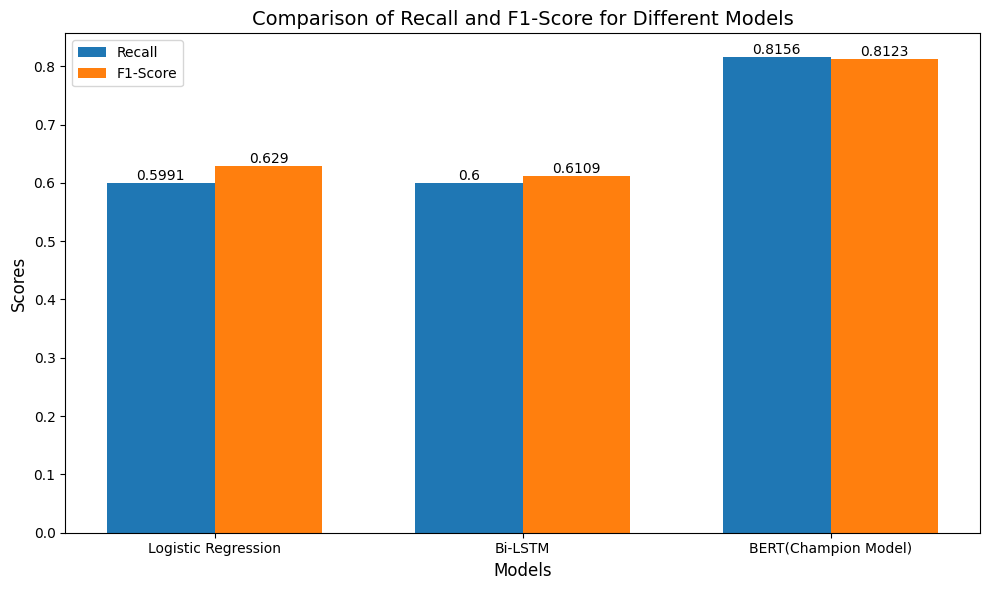

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Logistic Regression', 'Bi-LSTM', 'BERT(Champion Model)']

# Metrics
recall = [0.5991, 0.6000, 0.8156]
f1_score = [0.6290, 0.6109, 0.8123]

# Set the bar width and positions
bar_width = 0.35
x = np.arange(len(models))

# Create the bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for recall and F1-score with professional colors
bars1 = ax.bar(x - bar_width/2, recall, bar_width, label='Recall', color='#1f77b4')  # Blue
bars2 = ax.bar(x + bar_width/2, f1_score, bar_width, label='F1-Score', color='#ff7f0e')  # Orange

# Adding labels and title
ax.set_xlabel('Models', fontsize=12)
ax.set_ylabel('Scores', fontsize=12)
ax.set_title('Comparison of Recall and F1-Score for Different Models', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

# Adding data labels on top of the bars
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# Show the plot
plt.tight_layout()
plt.show()


## Summary of the Models
- Model 1: Best for cases where all classes are present, performs decent with smaller classes.
- Bert (Combined Classes): Performs better overall with combined classes, balancing well between majority and minority classes. 
- Model 3: Focuses on undersampling, offering improved performance for minority classes while maintaining decent overall accuracy.
    
#### BERT(Combined Classes) is the Champion Model which performs the best for every category of news articles.